# Example : REDOR

In [1]:
# git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from time import time
RS.Defaults['parallel']=True

In [5]:
%matplotlib notebook

## Build the spin system
For relaxation induced by exchange, we always build the spin system with at least two different sets of interactions. Not all interactions must change, but at least one interaction should be different– otherwise no relaxation will occure. Note that best-practice is to build the first spin-system, and copy it and only edit the parameters that are changed in the second spin-system.

pyRelaxSim takes the main experimental parameters (excepting rf fields) upon initialization of a spin-system, and then interactions are added afterwards.

In [2]:
ex0=RS.ExpSys(v0H=600,vr=60000,Nucs=['15N','1H'],pwdavg=RS.PowderAvg(q=6))     #1-spin system at 600 MHz (14.1 T)
delta=RS.Tools.dipole_coupling(.109,'1H','15N')       #Built-in dipole coupling calculator
ex0.set_inter(Type='dipole',i0=0,i1=1,delta=delta)    #Dipole coupling
ex1=ex0.copy()   #Copies the spin system
ex1.set_inter(Type='dipole',i0=0,i1=1,delta=delta,euler=[0,60*np.pi/180,0])   #60 degree hop of dipole coupling

## Define Liouvillian, pulse sequence, initial density operator, detection operator

In [3]:
L=RS.Liouvillian((ex0,ex1))  #Liovillian with both Hamiltonians
firsthalf=RS.Sequence(L)
secondhalf=RS.Sequence(L)
refocus=RS.Sequence(L)
v1H=150000
v1C=100000
tpiH=1/v1H/2
tpiC=1/v1C/2
shift=.15*L.taur
t=[0,L.taur/2+shift-tpiH,L.taur/2+shift,L.taur-tpiH,L.taur]
firsthalf.add_channel('1H',t=t,v1=[0,v1H,0,v1H,0],phase=[0,0,0,pi/2,0])   #Pulse sequence during homonuclear decoupling
secondhalf.add_channel('1H',t=L.taur-np.array(t[::-1]),v1=[v1H,0,v1H,0,0],phase=[pi/2,0,0,0,0])
refocus.add_channel('1H',t=[0,L.taur-tpiH/2,L.taur+tpiH/2,2*L.taur],v1=[0,v1H,0,0])
refocus.add_channel('15N',t=[0,L.taur-tpiC/2,L.taur+tpiC/2,2*L.taur],v1=[0,v1C,0,0])

## Visualize the parts of the sequence

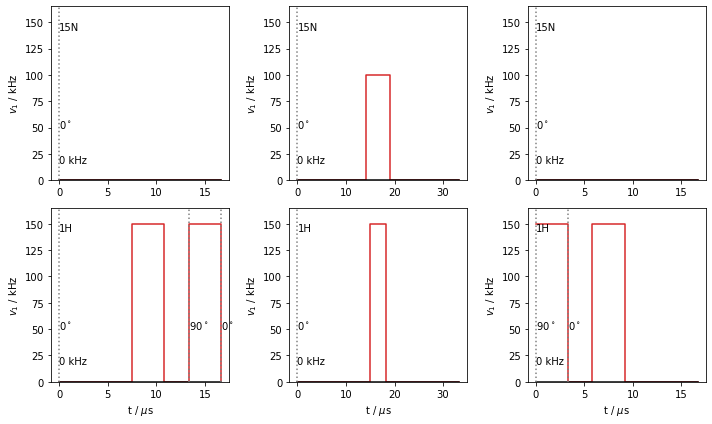

In [4]:
fig,ax=plt.subplots(2,3)
for a,seq in zip(ax.T,[firsthalf,refocus,secondhalf]):
    seq.plot(ax=a)
fig.set_size_inches([10,6])
fig.tight_layout()

## Prepare the propagators

In [6]:
L.kex=[[-.5e5,.5e5],[.5e5,-.5e5]]

Uf=firsthalf.U()
Uref=refocus.U()
Us=secondhalf.U()

0.06883597373962402


## Execute the sequence
First prepare the initial density operator and detection operator. Then loop over the time points

In [7]:
t0=time()
npts=75
rho=RS.Rho(rho0='15Nx',detect='15Nx')
Ufa=L.Ueye()
Usa=L.Ueye()
for k in range(npts):
    rho.reset()         #Reset density operator back to initial state
    (Usa*Uref*Ufa*rho)()   #Propagate by accumlated propagators and refocusing pulses. rho() acquires the result
    Ufa=Uf*Ufa          #Accumlate propagator for first half (add another rotor period for each loop)
    Usa=Us*Usa          #Accumlate propagator for second half
print(f"Total time elapsed: {time()-t0:.0f} seconds")    
rho.plot()

Process ForkPoolWorker-52:
Process ForkPoolWorker-54:
Process ForkPoolWorker-53:
Process ForkPoolWorker-49:
Process ForkPoolWorker-56:
Process ForkPoolWorker-55:
Process ForkPoolWorker-60:
Process ForkPoolWorker-50:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/albertsmith/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/albertsmith/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/albertsmith/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/albertsmith/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/albertsmith/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
  

  File "/Users/albertsmith/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/matfuncs.py", line 641, in _expm
    eta_1 = max(h.d4_loose, h.d6_loose)
  File "/Users/albertsmith/anaconda3/lib/python3.7/site-packages/scipy/linalg/matfuncs.py", line 255, in expm
    return scipy.sparse.linalg.expm(A)
  File "/Users/albertsmith/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/albertsmith/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/albertsmith/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/matfuncs.py", line 641, in _expm
    eta_1 = max(h.d4_loose, h.d6_loose)
  File "/Users/albertsmith/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/albertsmith/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/matfuncs.py", line 444, 

KeyboardInterrupt: 

## Compare different correlation times

### Obtain propagators for different correlation times

In [13]:
tc0=np.logspace(-9,-1,5)
Uf=list()
Uref=list()
Us=list()
t0=time()
for tc in tc0:
    L.kex=[[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]]
    L.reset_prop_time()
    Uf.append(firsthalf.U())
    Uref.append(refocus.U())
    Us.append(secondhalf.U())
print(time()-t0)

363.70019912719727


## Execute the sequence

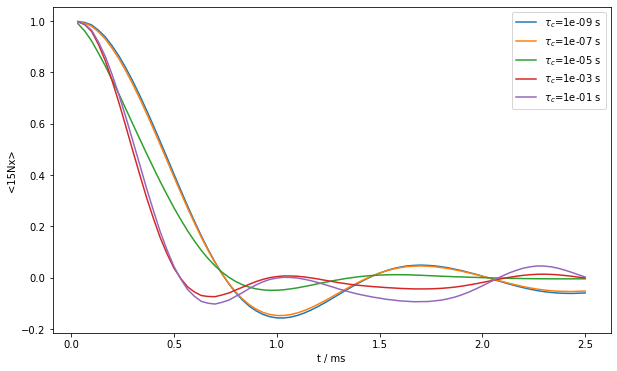

In [14]:
ax=plt.figure().add_subplot(111)

npts=75
rho=list()
for Uf0,Uref0,Us0 in zip(Uf,Uref,Us):
    rho.append(RS.Rho(rho0='15Nx',detect='15Nx'))
    Ufa=L.Ueye()
    Usa=L.Ueye()
    for k in range(npts):
        rho[-1].reset()         #Reset density operator back to initial state
        (Usa*Uref0*Ufa*rho[-1])()   #Propagate by accumlated propagators and refocusing pulses. rho() acquires the result
        Ufa=Uf0*Ufa          #Accumlate propagator for first half (add another rotor period for each loop)
        Usa=Us0*Usa          #Accumlate propagator for second half
        
    rho[-1].plot(ax=ax)
    
    
ax.legend([r'$\tau_c$='+f'{tc:.0e} s' for tc in tc0],loc='upper right')
ax.figure.set_size_inches([10,6])

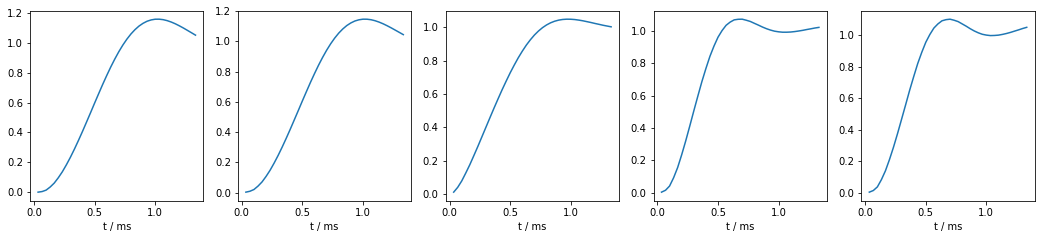

In [22]:
fig,ax=plt.subplots(1,5)
fig.set_size_inches([18,3.5])
for a,rho0 in zip(ax,rho):
    a.plot(rho0.t_axis[:40]*1e3,1-rho0.I.real[0][:40])
    a.set_xlabel('t / ms')

In [24]:
rho[0].Ipwd.shape

(299, 1, 75)

In [26]:
rho[0].I.shape

(1, 75)